In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

from copy import copy


from torchdiffeq import odeint, odeint_adjoint

import torch
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.nn.module import to_pyro_module_
from pyro.poutine import trace
from pyro.infer.autoguide.guides import AutoDelta,  AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam

In [2]:
def plot_predictive(prediction, data, title=""):
    t = np.linspace(0, 160, 160)
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    vars = ["S_obs", "V_obs", "I_obs", "Iv_obs", "R_obs"]
    S, V, I, Iv, R = [d.detach().numpy()/1000 for d in data]

    S_low, V_low, I_low, Iv_low, R_low = [torch.quantile(prediction[k], 0.05, dim=0).detach().numpy()/1000 for k in vars]
    S_up, V_up, I_up, Iv_up, R_up = [torch.quantile(prediction[k], 0.95, dim=0).detach().numpy()/1000 for k in vars]

    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.fill_between(t, S_low, S_up, color='b', alpha=0.2)
    ax.plot(t, V, 'purple', alpha=0.5, lw=2, label='SucceptibleVaccinated')
    ax.fill_between(t, V_low, V_up, color='purple', alpha=0.2)
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.fill_between(t, I_low, I_up, color='r', alpha=0.2)
    ax.plot(t, Iv, 'green', alpha=0.5, lw=2, label='InfectedVaccinated')
    ax.fill_between(t, Iv_low, Iv_up, color='green', alpha=0.2)
    ax.plot(t, R, 'orange', alpha=0.5, lw=2, label='Recovered')
    ax.fill_between(t, R_low, R_up, color='orange', alpha=0.2)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title(title)
    plt.show()

In [3]:
def get_tspan(start, end, steps):
    return torch.linspace(float(start), float(end), steps)

In [4]:
class SVIIvR(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.N, self.beta, self.betaV, self.gamma, self.gammaV, self.nu = params
        self.t0 = torch.as_tensor([0.0])
        
    def forward(self, t, state):
        S, V, I, Iv, R = state
        dSdt = -self.beta  * S * I  / self.N - self.beta  * S * Iv / self.N - self.nu * S 
        dVdt = -self.betaV * V * Iv / self.N - self.betaV * V * I  / self.N + self.nu * S
        dIdt =  self.beta  * S * I  / self.N + self.beta  * S * Iv / self.N - self.gamma  * I 
        dIvdt = self.betaV * V * I  / self.N + self.betaV * V * Iv / self.N - self.gammaV * Iv 
        dRdt =  self.gamma * I + self.gammaV * Iv

        return dSdt, dVdt, dIdt, dIvdt, dRdt
    

In [5]:
class SVIIvR(PyroModule):
    def __init__(self, 
                N,
                noise_var=10.,
                beta_prior=dist.Uniform(0.15, 0.25), 
                betaV_prior=dist.Uniform(0.1, 0.2),
                gamma_prior=dist.Uniform(0.05, 0.15),
                gammaV_prior=dist.Uniform(0.1, 0.2),
                nu_prior=dist.Uniform(0.02, 0.08),
                ):
        super().__init__()

        self.N = N
        self.noise_var    = noise_var
        self.beta_prior   = beta_prior
        self.betaV_prior  = betaV_prior
        self.gamma_prior  = gamma_prior
        self.gammaV_prior = gammaV_prior
        self.nu_prior     = nu_prior
        
        self.t0 = torch.as_tensor([0.0])
        
    def forward(self, t, state):
        S, V, I, Iv, R = state
        dSdt  = -self.beta  * S * I  / self.N - self.beta  * S * Iv / self.N - self.nu * S 
        dVdt  = -self.betaV * V * Iv / self.N - self.betaV * V * I  / self.N + self.nu * S
        dIdt  =  self.beta  * S * I  / self.N + self.beta  * S * Iv / self.N - self.gamma  * I 
        dIvdt = self.betaV * V * I  / self.N + self.betaV * V * Iv / self.N - self.gammaV * Iv 
        dRdt  =  self.gamma * I + self.gammaV * Iv

        return dSdt, dVdt, dIdt, dIvdt, dRdt

    def simulate(self, initial_state, tspan, S_obs=None, V_obs=None, I_obs=None, Iv_obs=None, R_obs=None):
        self.beta   = pyro.sample("beta", self.beta_prior)
        self.betaV  = pyro.sample("betaV", self.betaV_prior)
        self.gamma  = pyro.sample("gamma", self.gamma_prior)
        self.gammaV = pyro.sample("gammaV", self.gammaV_prior)
        self.nu     = pyro.sample("nu", self.nu_prior)

        # Simulate from ODE
        S_, V_, I_, Iv_, R_ = odeint(self, initial_state, tspan)
        
        # Add Observation noise
        S = pyro.sample("S_obs", dist.Normal(S_, self.noise_var).to_event(1), obs=S_obs)
        V = pyro.sample("V_obs", dist.Normal(V_, self.noise_var).to_event(1), obs=V_obs)
        I = pyro.sample("I_obs", dist.Normal(I_, self.noise_var).to_event(1), obs=I_obs)
        Iv = pyro.sample("Iv_obs", dist.Normal(Iv_, self.noise_var).to_event(1), obs=Iv_obs)
        R = pyro.sample("R_obs", dist.Normal(R_, self.noise_var).to_event(1), obs=R_obs)

        return S, V, I, Iv, R


In [6]:
# Total population, N.
N = 1000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0,  = 0.0, 1.0, 0.0, 0.0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
tspan = get_tspan(0, 160, 160)



In [7]:
# Generate data
ode_model = SVIIvR(N)
S_obs, V_obs, I_obs, Iv_obs, R_obs = ode_model.simulate(initial_state, tspan)


/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_53300/161055048.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


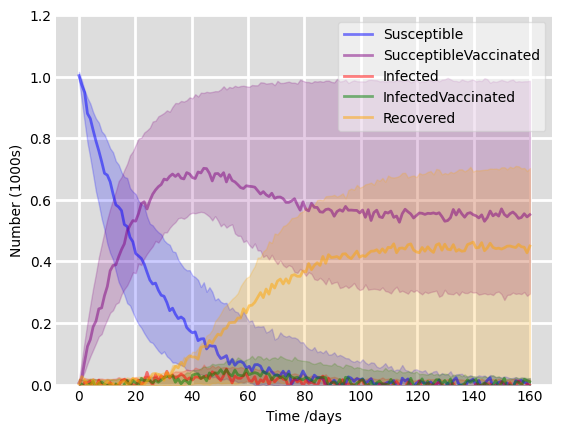

In [8]:
prior_prediction = Predictive(ode_model.simulate, num_samples=100)(initial_state, tspan)
plot_predictive(prior_prediction, (S_obs, V_obs, I_obs, Iv_obs, R_obs))

In [11]:
verbose = True
num_iterations = 250

guide = AutoNormal(ode_model.simulate)
optim = Adam({'lr':0.03})
elbo = Trace_ELBO(num_particles=1)

svi = SVI(ode_model.simulate, guide, optim, loss=elbo)

pyro.clear_param_store()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(initial_state, tspan, S_obs=S_obs, V_obs=V_obs, I_obs=I_obs, Iv_obs=Iv_obs, R_obs=R_obs)
    if verbose:
        if j % 25 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 0001] loss: 101616.5046
[iteration 0026] loss: 6637.6969
[iteration 0051] loss: 6598.7379
[iteration 0076] loss: 5177.9441
[iteration 0101] loss: 5546.5811
[iteration 0126] loss: 5062.3111
[iteration 0151] loss: 4252.2114
[iteration 0176] loss: 4584.1384
[iteration 0201] loss: 4308.2431
[iteration 0226] loss: 4040.3191


/var/folders/pr/rxyls1rd481ddqv0c4jw9b9w0000gn/T/ipykernel_53300/161055048.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


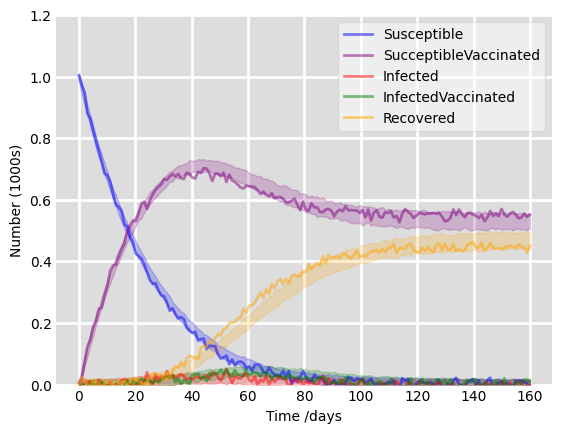

In [ ]:
posterior_prediction = Predictive(ode_model.simulate, guide=guide, num_samples=100)(initial_state, tspan)
plot_predictive(posterior_prediction, (S_obs, V_obs, I_obs, Iv_obs, R_obs))